## UFPR04
![]("dataset/UFPR04_sample.jpg")

In [1]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR04'
# Get all images in path
files = glob.glob(path + '/**/*.jpg', recursive=True)
# Select n random images from dataset
selected_files = random.choices(files, k=int(len(files)/10))

# params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR
# params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05



Processing 379 files with 12 cores


100%|██████████| 379/379 [01:33<00:00,  4.05it/s]

Precision: 0.911
specificity: 0.910
Recall: 0.842
F1 Score: 0.875
Accuracy: 0.874


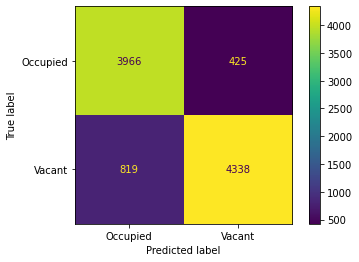

(0.9112920058442914,
 0.9095552245158545,
 0.8420443587270974,
 0.8753007217321572,
 0.8741400242816674)

In [3]:
gaussianBlurKernel = (5, 5)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 29           # Tamaño vecindad umbral adaptativo
at_C = 8                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 23                # Umbral Eliminar objetos pequeños
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold=0.26)  # UFPR04

confusion_matrix, real, predicted = process_batch(selected_files, params)
show_confusion_matrix(confusion_matrix, real, predicted)

Processing 379 files with 12 cores


100%|██████████| 379/379 [01:38<00:00,  3.83it/s]


Precision: 0.922
Recall: 0.839
F1 Score: 0.879
Accuracy: 0.869


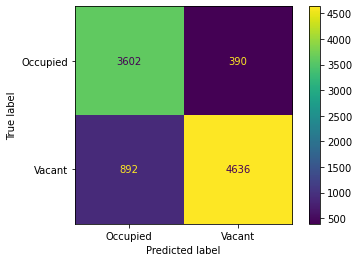

In [4]:
gaussianBlurKernel = (5, 5)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 29           # Tamaño vecindad umbral adaptativo
at_C = 8                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 23                # Umbral Eliminar objetos pequeños
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size)  # UFPR04

confusion_matrix, real, predicted = process_batch(selected_files, params,  vacant_threshold=0.26)
show_confusion_matrix(confusion_matrix, real, predicted)

Processing 379 files with 12 cores


100%|██████████| 379/379 [01:34<00:00,  4.02it/s]

Precision: 0.852
Recall: 0.960
F1 Score: 0.903
Accuracy: 0.883


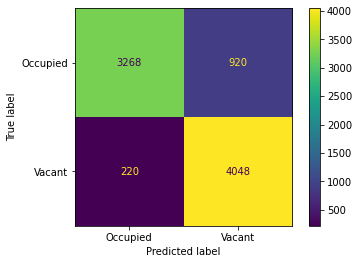

In [5]:
gaussianBlurKernel = (5,5)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 29           # Tamaño vecindad umbral adaptativo
at_C = 10                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 25                # Umbral Eliminar objetos pequeños 
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma, cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size) # UFPR04

confusion_matrix, real, predicted = process_batch(selected_files, params, vacant_threshold=0.26)
show_confusion_matrix(confusion_matrix, real, predicted)

## PUCPR

In [6]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\PUCPR'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

Processing 447 files with 12 cores


100%|██████████| 447/447 [02:10<00:00,  3.42it/s]


Precision: 0.935
Recall: 0.890
F1 Score: 0.912
Accuracy: 0.910


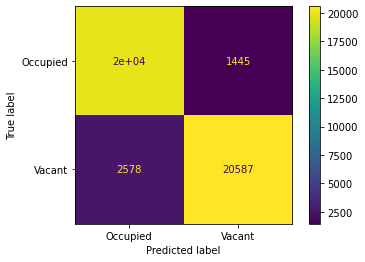

In [7]:
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR
confusion_matrix, real, predicted = process_batch(selected_files, params,  vacant_threshold=0.26)
show_confusion_matrix(confusion_matrix, real, predicted)

## UPR05

In [8]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

# params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR05'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

Processing 415 files with 12 cores


100%|██████████| 415/415 [01:11<00:00,  5.82it/s]

Precision: 0.890
Recall: 0.794
F1 Score: 0.839
Accuracy: 0.869


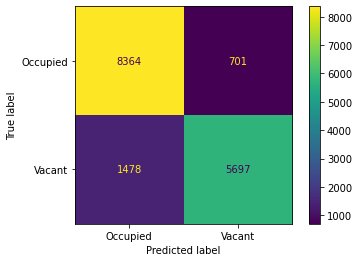

In [9]:
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 9, 3, 305) # UPR05
confusion_matrix, real, predicted = process_batch(selected_files, params,  vacant_threshold=0.22)
show_confusion_matrix(confusion_matrix, real, predicted)